In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from fisting import fit_catboost, fit_et, fit_lgbm, fit_rf, objective
from sklearn.ensemble import RandomForestClassifier

# feature selection again
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

random.seed(0)
np.random.seed(0)


df_train = pd.read_excel("train.xlsx")
df_test = pd.read_excel("test.xlsx")

In [ ]:
df_train

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
3,3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3
4,4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,26169,20230310-7492-177993190,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2023-01-07 17:45:18,NaT,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26170,26170,20230625-16563-206126520,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-20 17:54:17,NaT,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4
26171,26171,20220624-7492-137587082,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),2022-05-08 19:24:05,NaT,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26172,26172,20220427-7491-125459150,1,6300.0,0,Гарантия банковской картой,2022-02-19 09:55:50,2022-04-16 23:14:35,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3


In [ ]:
df_train["target"] = df_train["Дата отмены"].apply(lambda x: int(pd.notna(x)))

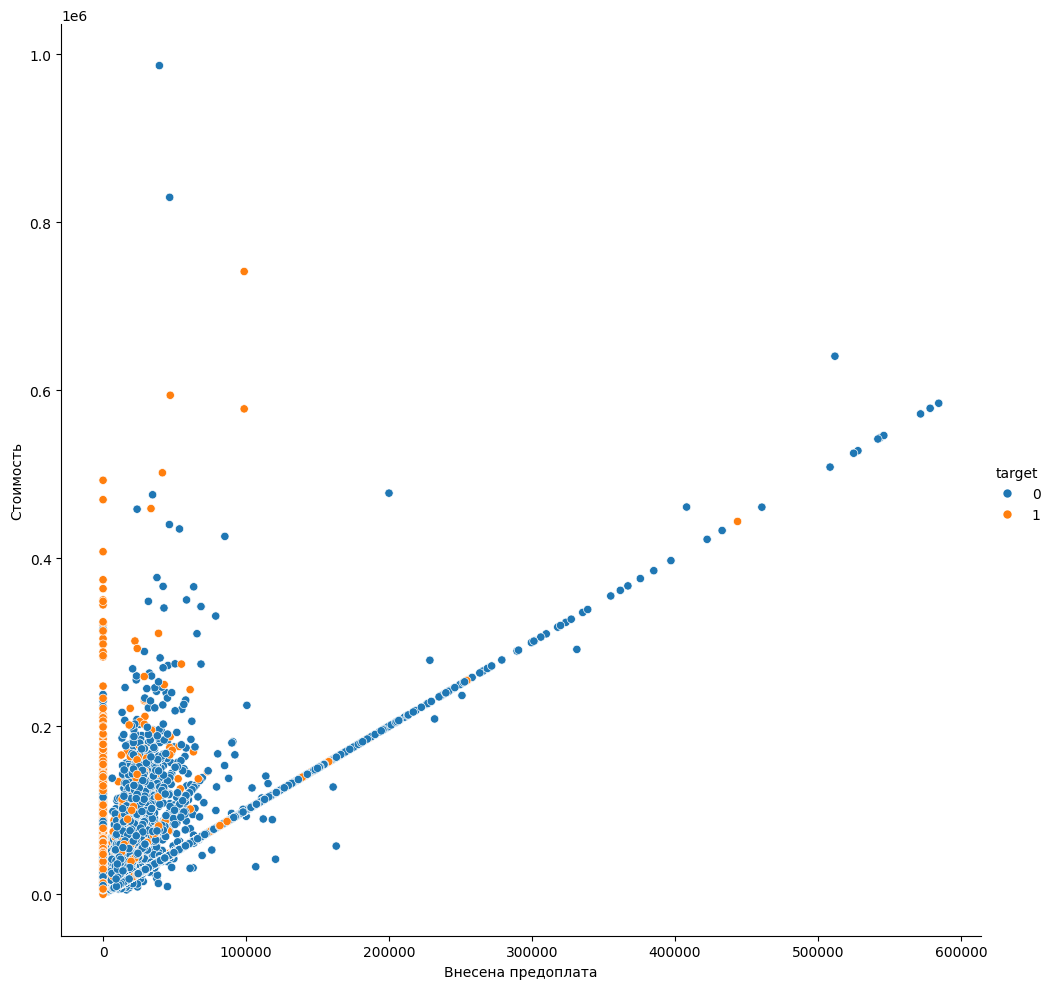

In [ ]:
sns.relplot(df_train, hue="target", x="Внесена предоплата", y="Стоимость", height=10)

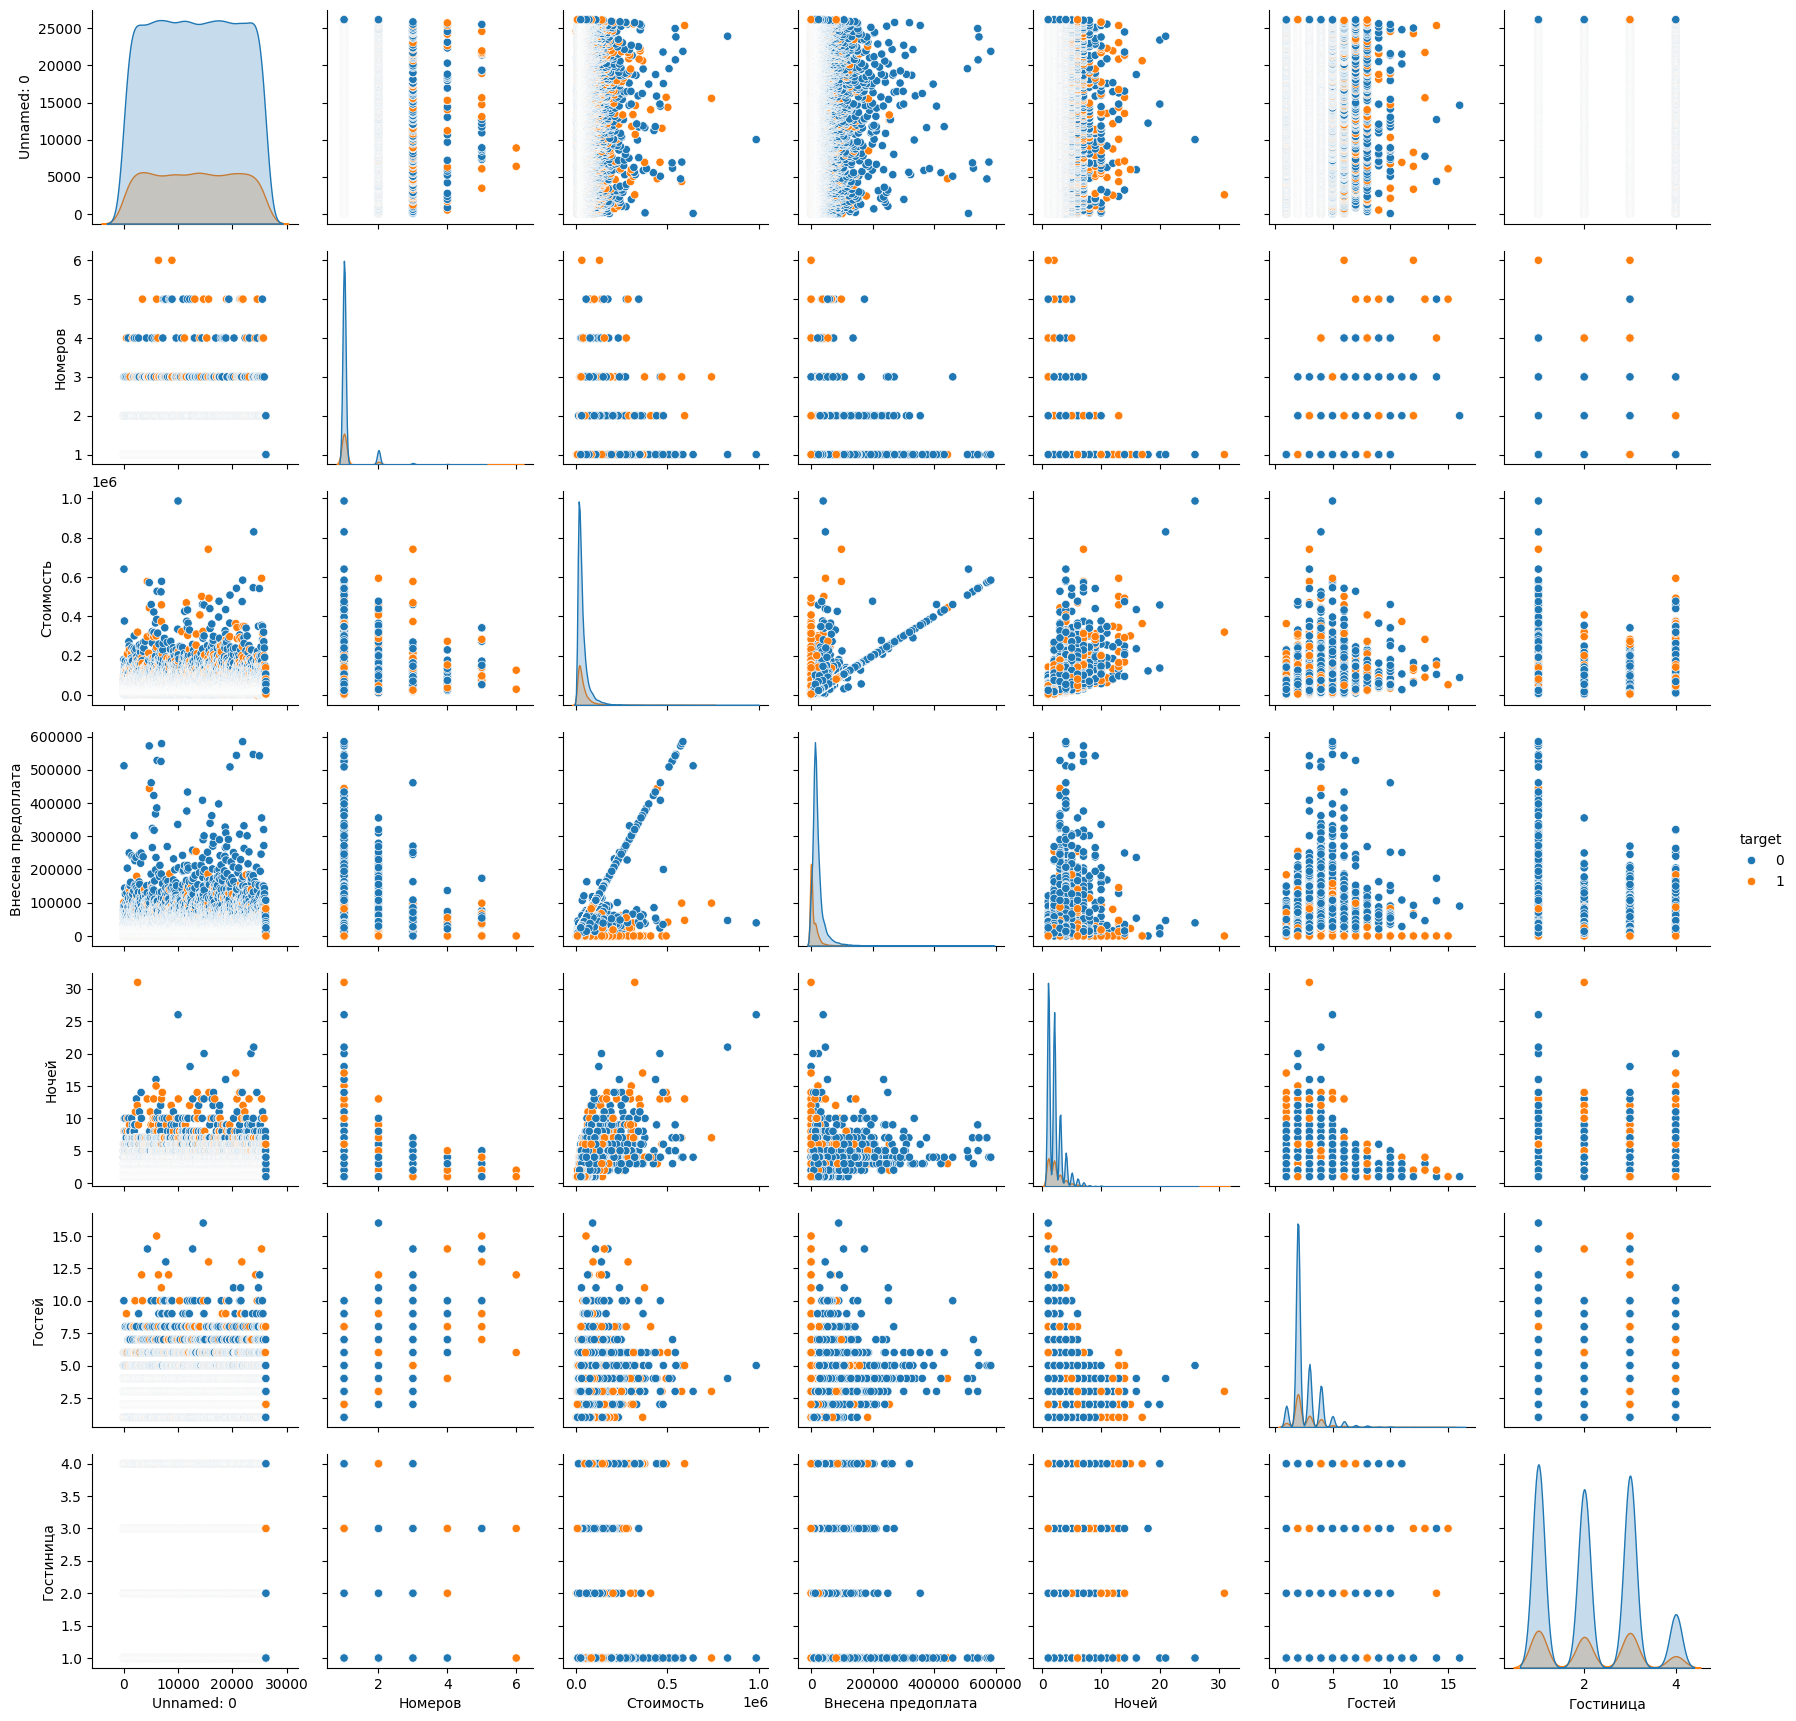

In [ ]:
sns.pairplot(df_train, hue="target")

/tmp/ipykernel_2286943/3743032447.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');


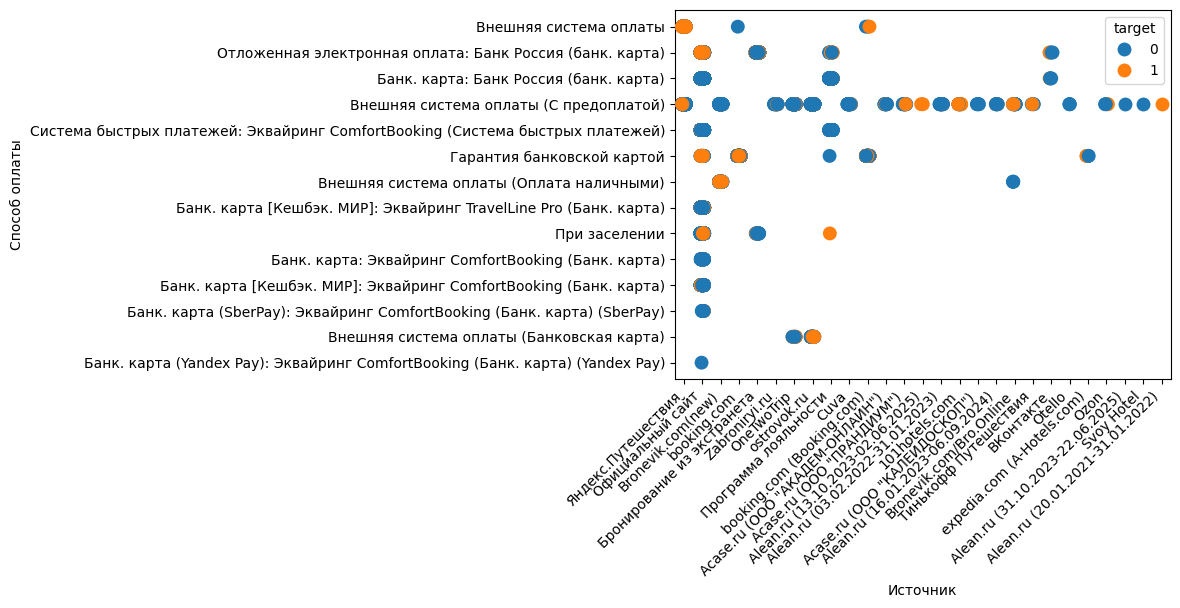

In [ ]:
g = sns.stripplot(data=df_train, y="Способ оплаты", x="Источник", hue="target", size=10)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment="right");

/tmp/ipykernel_2286943/4057588524.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');


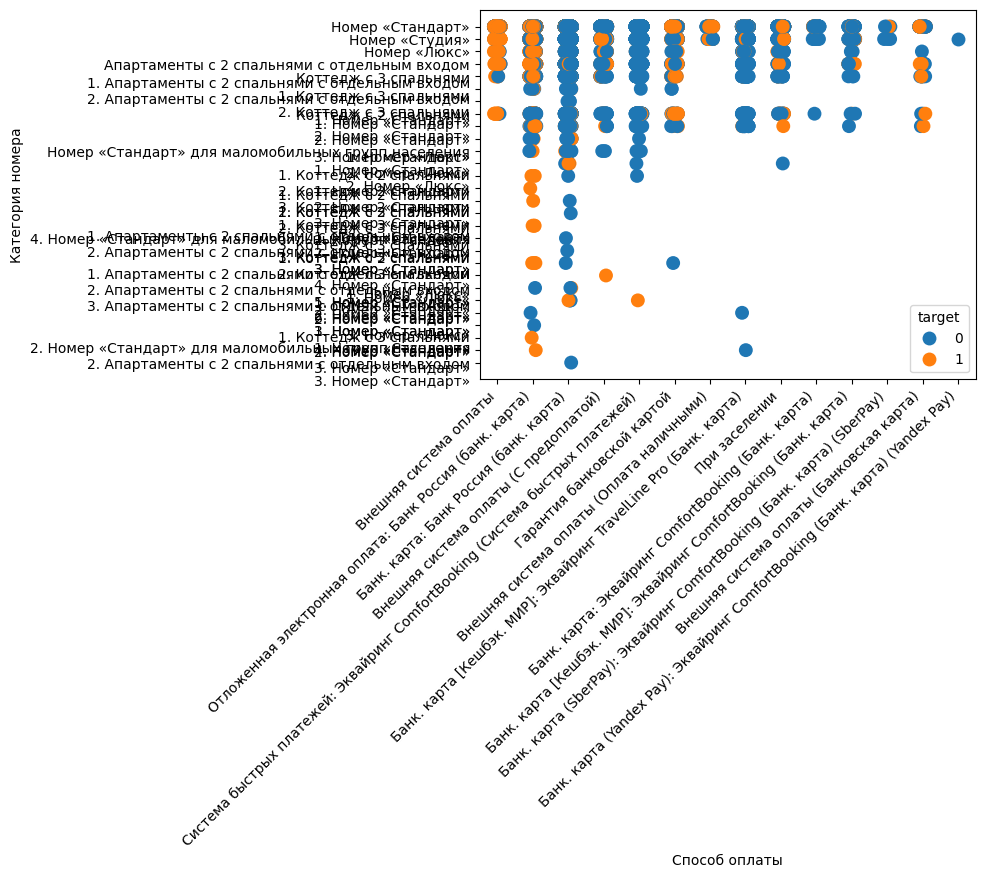

In [ ]:
g = sns.stripplot(
    data=df_train, x="Способ оплаты", y="Категория номера", hue="target", size=10
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment="right");

/tmp/ipykernel_2286943/2520822973.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');


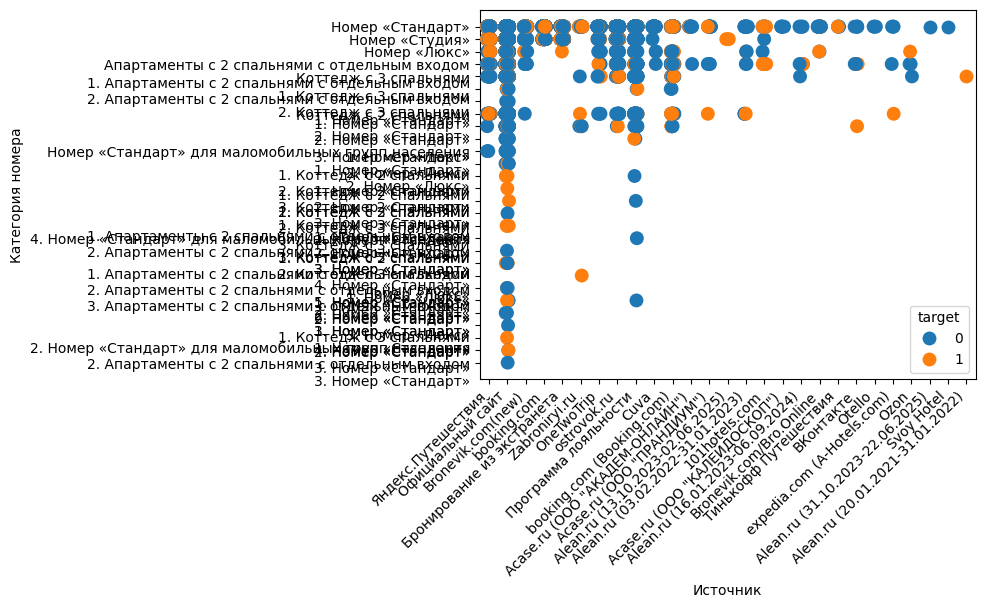

In [ ]:
g = sns.stripplot(
    data=df_train, y="Категория номера", x="Источник", hue="target", size=10
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment="right");

In [ ]:
df_train["target"] = df_train["Дата отмены"].apply(lambda x: int(pd.notna(x)))

In [ ]:
def prepare_df(df):
    df = df.copy()
    df = df.drop(["Unnamed: 0", "№ брони"], axis=1)
    df["Дата бронирования"] = pd.to_datetime(df["Дата бронирования"])
    df["Заезд"] = pd.to_datetime(df["Заезд"])
    df["Выезд"] = pd.to_datetime(df["Выезд"])
    return df


def create_date_features(df, prefix):
    df = df.copy()
    df[prefix + "_month"] = df[prefix].dt.month.astype("int8")
    df[prefix + "_day_of_month"] = df[prefix].dt.day.astype("int8")
    df[prefix + "_day_of_year"] = df[prefix].dt.dayofyear.astype("int16")
    df[prefix + "_week_of_month"] = (
        df[prefix].apply(lambda d: (d.day - 1) // 7 + 1)
    ).astype("int8")
    df[prefix + "_week_of_year"] = (df[prefix].dt.isocalendar().week).astype("int8")
    df[prefix + "_day_of_week"] = (df[prefix].dt.dayofweek + 1).astype("int8")
    df[prefix + "_year"] = df[prefix].dt.year.astype("int32")
    df[prefix + "_is_wknd"] = (df[prefix].dt.weekday // 4).astype("int8")
    df[prefix + "_season"] = np.where(df[prefix + "_month"].isin([12, 1, 2]), 0, 1)
    df[prefix + "_season"] = np.where(
        df[prefix + "_month"].isin([6, 7, 8]), 2, df[prefix + "_season"]
    )
    df[prefix + "_season"] = pd.Series(
        np.where(df[prefix + "_month"].isin([9, 10, 11]), 3, df[prefix + "_season"])
    ).astype("int8")
    return df


def create_diff_features(df, prefix1, prefix2):
    df = df.copy()
    df[prefix1 + "_" + prefix2 + "_diff_in_days"] = (df[prefix1] - df[prefix2]).dt.days
    df[prefix1 + "_" + prefix2 + "_diff_in_weeks"] = (
        df[prefix1 + "_" + prefix2 + "_diff_in_days"] / 7
    )
    df[prefix1 + "_" + prefix2 + "_diff_in_hours"] = (
        df[prefix1] - df[prefix2]
    ).dt.total_seconds() / 3600
    return df


def create_payment_method_features(df):
    df = df.copy()
    df["SberPay"] = df["Способ оплаты"].apply(lambda x: int("SberPay" in x))
    df["Yandex Pay"] = df["Способ оплаты"].apply(lambda x: int("Yandex Pay" in x))
    df["МИР"] = df["Способ оплаты"].apply(lambda x: int("МИР" in x))
    df["ComfortBooking"] = df["Способ оплаты"].apply(lambda x: int("ComfortBooking" in x))
    df["TravelLine Pro"] = df["Способ оплаты"].apply(lambda x: int("TravelLine Pro" in x))
    df["Банк Россия"] = df["Способ оплаты"].apply(lambda x: int("Банк Россия" in x))
    df["Внешняя система оплаты"] = df["Способ оплаты"].apply(
        lambda x: int("Внешняя система оплаты" in x)
    )
    df["Банковская карта"] = df["Способ оплаты"].apply(
        lambda x: int(
            "Банковская карта" in x
            or "Банк. карта".lower() in x.lower()
            or "банковской картой".lower() in x.lower()
        )
    )
    df["Оплата наличными"] = df["Способ оплаты"].apply(
        lambda x: int("Оплата наличными" in x)
    )
    df["С предоплатой"] = df["Способ оплаты"].apply(lambda x: int("С предоплатой" in x))
    df["СБП"] = df["Способ оплаты"].apply(lambda x: int("Система быстрых платежей" in x))

    df["Отложенная электронная оплата"] = df["Способ оплаты"].apply(
        lambda x: int("Отложенная электронная оплата" in x)
    )

    df["Гарантия банковской картой"] = df["Способ оплаты"].apply(
        lambda x: int("Гарантия банковской картой" in x)
    )

    df["При заселении"] = df["Способ оплаты"].apply(lambda x: int("При заселении" in x))

    return df


def clear_source_column(text):
    # good
    mapping = [
        "Официальный сайт",
        "Бронирование из экстранета",
        "Яндекс.Путешествия",
        "ostrovok",
        "booking",
        "Программа лояльности",
        "Bronevik",
        "OneTwoTrip",
    ]

    for map_ in mapping:
        if map_.lower() in text.lower():
            return map_
    return "other"


def clear_category(text):
    # good
    if "\n" in text:
        text = text.split("\n")
        text = text[0]
    text = text.strip("1. ")
    return text

In [ ]:
def preprocess_df(df):
    df = df.copy()
    df = prepare_df(df)
    df = create_date_features(df, "Дата бронирования")
    df = create_date_features(df, "Заезд")
    df = create_date_features(df, "Выезд")
    df = create_diff_features(df, "Заезд", "Дата бронирования")
    df = create_diff_features(df, "Выезд", "Заезд")

    df = create_payment_method_features(df)

    df["Источник"] = df["Источник"].apply(clear_source_column)

    df["Категория multiple selection"] = df["Категория номера"].apply(
        lambda x: int("\n" in x)
    )

    df["Категория номера"] = df["Категория номера"].apply(clear_category)

    # other features

    df["Стоимость за ночь"] = df["Стоимость"] / df["Ночей"]
    df["Внесена предоплата binary"] = df.apply(
        lambda x: int(x["Внесена предоплата"] != 0), axis=1
    )

    df["Предоплата умноженная на время до прибытия"] = (
        df["Внесена предоплата"] * df["Заезд_Дата бронирования_diff_in_days"]
    )

    df["Процент предоплата от стоимости"] = df["Внесена предоплата"] / df["Стоимость"]
    df["Гостей на номер"] = df["Гостей"] / df["Номеров"]

    df["Стоимость на гостя"] = df["Стоимость"] / df["Гостей"]
    df["Стоимость за номер"] = df["Стоимость"] / df["Номеров"]
    df["Стоимость за ночь 1 номер"] = df["Стоимость"] / df["Ночей"] / df["Номеров"]
    df["Стоимость за ночь 1 гостя"] = df["Стоимость"] / df["Ночей"] / df["Гостей"]
    df["Гостей на номер"] = df["Гостей"] / df["Номеров"]
    df["Бронирование утром"] = df["Дата бронирования"].apply(
        lambda x: (
            1
            if x.time() >= pd.Timestamp("05:00:00").time()
            and x.time() < pd.Timestamp("11:00:00").time()
            else 0
        )
    )
    df["Бронирование вечером"] = df["Дата бронирования"].apply(
        lambda x: (
            1
            if x.time() >= pd.Timestamp("17:00:00").time()
            and x.time() < pd.Timestamp("23:00:00").time()
            else 0
        )
    )
    df["Бронирование ночью"] = df["Дата бронирования"].apply(
        lambda x: (
            1
            if x.time() >= pd.Timestamp("23:00:00").time()
            or x.time() < pd.Timestamp("05:00:00").time()
            else 0
        )
    )
    return df

In [ ]:
df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)

In [ ]:
# drops
df_train = df_train.drop(["Дата бронирования", "Заезд", "Выезд"], axis=1)
df_test = df_test.drop(["Дата бронирования", "Заезд", "Выезд"], axis=1)

In [ ]:
df_train["target"] = df_train["Дата отмены"].apply(lambda x: int(pd.notna(x)))
df_train = df_train.drop(["Дата отмены", "Статус брони"], axis=1)

In [ ]:
X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

In [ ]:
# for forests
encoder = OneHotEncoder(drop="first", sparse_output=False)
cat_columns = X_train.select_dtypes(include=["object"]).columns
X_train_forest = pd.concat(
    [
        X_train.drop(cat_columns, axis=1),
        pd.DataFrame(
            encoder.fit_transform(X_train[cat_columns]),
            columns=encoder.get_feature_names_out(),
        ),
    ],
    axis=1,
)
df_test_forest = pd.concat(
    [
        df_test.drop(cat_columns, axis=1),
        pd.DataFrame(
            encoder.transform(df_test[cat_columns]),
            columns=encoder.get_feature_names_out(),
        ),
    ],
    axis=1,
)

# for lgbm
X_train_lgbm = X_train.copy()
df_test_lgbm = df_test.copy()
for cat in cat_columns:
    X_train_lgbm[cat] = X_train_lgbm[cat].astype("category")
    df_test_lgbm[cat] = df_test_lgbm[cat].astype("category")

In [ ]:
SEARCH_BEST_PARAMS = True
N_TRIALS = 30
CAT_FEATURES = ["Способ оплаты", "Источник", "Категория номера"]
RANDOM_SEED = 42
EVAL_METRIC = "AUC"
EARLY_STOPPING = 50

In [ ]:
selector = RFECV(
    CatBoostClassifier(
        verbose=0,
        # eval_metric=EVAL_METRIC,
        # early_stopping_rounds=EARLY_STOPPING,
    ),
    step=1,
    min_features_to_select=15,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring="roc_auc",
    # without early stopping, cannot pass val set
)

selector = selector.fit(X_train_forest, y_train)

In [ ]:
# catboost is good on defaults
models_list = []
scores_list = []
y_pred = np.zeros(df_test.shape[0])
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (train_index, test_index) in enumerate(splitter.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
    X_fold_test, y_fold_test = X_train.iloc[test_index], y_train.iloc[test_index]

    model = CatBoostClassifier(
        cat_features=CAT_FEATURES,
        verbose=0,
        eval_metric=EVAL_METRIC,
        early_stopping_rounds=EARLY_STOPPING,
    )

    model.fit(X_fold_train, y_fold_train, eval_set=(X_fold_test, y_fold_test))

    preds = model.predict_proba(X_fold_test)[:, 1]
    score = roc_auc_score(y_fold_test, preds)

    models_list.append(model)
    scores_list.append(score)

np.mean(scores_list), np.std(scores_list)

(0.8604038938620333, 0.006062816823753102)

In [ ]:
if SEARCH_BEST_PARAMS:
    study = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
    )
    study.optimize(
        lambda trial: objective(trial, X_train_lgbm, y_train, "LightGBM"),
        n_trials=N_TRIALS - 15,
        show_progress_bar=True,
    )

[I 2024-09-21 21:56:14,953] A new study created in memory with name: no-name-0b654a55-3330-455c-949a-2538d7371036


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-09-21 21:58:19,366] Trial 0 finished with value: 0.8583994683558867 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.055238410897498764, 'feature_fraction': 0.4348501673009197, 'lambda_l1': 8.661895281603577, 'lambda_l2': 6.011549002420345, 'min_child_samples': 72, 'bagging_fraction': 0.41235069657748147, 'bagging_freq': 7}. Best is trial 0 with value: 0.8583994683558867.
[I 2024-09-21 21:58:25,624] Trial 1 finished with value: 0.8600574020899071 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.16217936517334897, 'feature_fraction': 0.6591670111852694, 'lambda_l1': 2.913000172840221, 'lambda_l2': 6.118917094329073, 'min_child_samples': 18, 'bagging_fraction': 0.5752867891211308, 'bagging_freq': 3}. Best is trial 1 with value: 0.8600574020899071.
[I 2024-09-21 21:59:55,914] Trial 2 finished with value: 0.8602790611151823 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_dep

KeyboardInterrupt: 

In [ ]:
if SEARCH_BEST_PARAMS:
    lgbm_best_params = study.best_params
else:
    lgbm_best_params = {
        "boosting_type": "dart",
        "num_leaves": 80,
        "max_depth": 8,
        "learning_rate": 0.02353980066877352,
        "feature_fraction": 0.7146404372369975,
        "lambda_l1": 2.9294801014827625,
        "lambda_l2": 4.301118582479693,
        "min_child_samples": 85,
        "bagging_fraction": 0.8207939948373919,
        "bagging_freq": 3,
    }

lgbm_best_value, lgbm_best_models = objective(
    optuna.trial.FixedTrial(lgbm_best_params),
    X_train_lgbm,
    y_train,
    "LightGBM",
    return_models=True,
)

print(f"Best LightGBM RMSE: {lgbm_best_value}\n\n")
print("Best LightGBM params:")
print(*[f"'{key}': {value}," for key, value in lgbm_best_params.items()], sep="\n")

Best LightGBM RMSE: 0.8611098264769588


Best LightGBM params:
'boosting_type': dart,
'num_leaves': 80,
'max_depth': 8,
'learning_rate': 0.02353980066877352,
'feature_fraction': 0.7146404372369975,
'lambda_l1': 2.9294801014827625,
'lambda_l2': 4.301118582479693,
'min_child_samples': 85,
'bagging_fraction': 0.8207939948373919,
'bagging_freq': 3,


In [ ]:
if SEARCH_BEST_PARAMS:
    study = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
    )
    study.optimize(
        lambda trial: objective(trial, X_train_forest, y_train, "RandomForest"),
        n_trials=N_TRIALS,
        n_jobs=-1,
        show_progress_bar=True,
    )

[I 2024-09-21 22:34:28,072] A new study created in memory with name: no-name-b3153734-6743-45ee-b44b-751212972ae8


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-09-21 22:36:22,785] Trial 8 finished with value: 0.8543033831840481 and parameters: {'n_estimators': 94, 'max_depth': 15, 'min_samples_split': 48, 'min_samples_leaf': 45, 'max_features': 0.08342036906580597}. Best is trial 8 with value: 0.8543033831840481.
[I 2024-09-21 22:36:24,813] Trial 9 finished with value: 0.8594489110962236 and parameters: {'n_estimators': 86, 'max_depth': 8, 'min_samples_split': 42, 'min_samples_leaf': 36, 'max_features': 0.5906680603149131}. Best is trial 9 with value: 0.8594489110962236.
[I 2024-09-21 22:36:59,678] Trial 3 finished with value: 0.856373796720647 and parameters: {'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 35, 'max_features': 0.23902912385045083}. Best is trial 9 with value: 0.8594489110962236.
[I 2024-09-21 22:37:34,469] Trial 7 finished with value: 0.8604503664788649 and parameters: {'n_estimators': 185, 'max_depth': 17, 'min_samples_split': 11, 'min_samples_leaf': 44, 'max_features': 0.16164208210

In [ ]:
# Вывод лучших параметров и метрик
if SEARCH_BEST_PARAMS:
    rf_best_params = study.best_params
else:
    rf_best_params = {
        "n_estimators": 425,
        "max_depth": 31,
        "min_samples_split": 33,
        "min_samples_leaf": 44,
        "max_features": 0.38331686104122775,
    }

rf_best_value, rf_best_models = objective(
    optuna.trial.FixedTrial(rf_best_params),
    X_train_forest,
    y_train,
    "RandomForest",
    return_models=True,
)

print(f"Best Random Forest RMSE: {rf_best_value}\n\n")
print("Best Random Forest params:")
print(*[f"'{key}': {value}," for key, value in rf_best_params.items()], sep="\n")

Best Random Forest RMSE: 0.8612870466853071


Best Random Forest params:
'n_estimators': 425,
'max_depth': 31,
'min_samples_split': 33,
'min_samples_leaf': 44,
'max_features': 0.38331686104122775,


In [ ]:
if SEARCH_BEST_PARAMS:
    study = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
    )
    study.optimize(
        lambda trial: objective(trial, X_train_forest, y_train, "ExtraTrees"),
        n_trials=N_TRIALS - 15,
        n_jobs=1,
        show_progress_bar=True,
    )

[I 2024-09-21 22:44:54,418] A new study created in memory with name: no-name-a75b9a82-c594-402a-a038-c6cc79c6c16f


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-21 22:44:59,396] Trial 0 finished with value: 0.8551317486861899 and parameters: {'n_estimators': 218, 'max_depth': 31, 'min_samples_split': 37, 'min_samples_leaf': 30, 'max_features': 0.15601864044243652}. Best is trial 0 with value: 0.8551317486861899.
[I 2024-09-21 22:45:01,395] Trial 1 finished with value: 0.846770334777635 and parameters: {'n_estimators': 120, 'max_depth': 3, 'min_samples_split': 44, 'min_samples_leaf': 31, 'max_features': 0.7080725777960455}. Best is trial 0 with value: 0.8551317486861899.
[I 2024-09-21 22:45:03,062] Trial 2 finished with value: 0.8585579156835859 and parameters: {'n_estimators': 59, 'max_depth': 32, 'min_samples_split': 42, 'min_samples_leaf': 11, 'max_features': 0.18182496720710062}. Best is trial 2 with value: 0.8585579156835859.
[I 2024-09-21 22:45:06,712] Trial 3 finished with value: 0.8599164836062212 and parameters: {'n_estimators': 132, 'max_depth': 11, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 0.29122914

In [ ]:
# Вывод лучших параметров и метрик
if SEARCH_BEST_PARAMS:
    et_best_params = study.best_params
else:
    et_best_params = {
        "n_estimators": 497,
        "max_depth": 13,
        "min_samples_split": 33,
        "min_samples_leaf": 17,
        "max_features": 0.5950385565501397,
    }

et_best_value, et_best_models = objective(
    optuna.trial.FixedTrial(et_best_params),
    X_train_forest,
    y_train,
    "ExtraTrees",
    return_models=True,
)

print(f"Best Extra Trees RMSE: {et_best_value}\n\n")
print("Best Extra Trees params:")
print(*[f"'{key}': {value}," for key, value in et_best_params.items()], sep="\n")

Best Extra Trees RMSE: 0.8608913874445427


Best Extra Trees params:
'n_estimators': 497,
'max_depth': 13,
'min_samples_split': 33,
'min_samples_leaf': 17,
'max_features': 0.5950385565501397,


In [ ]:
catboost_y_pred = np.zeros(df_test.shape[0])

for model in models_list:
    catboost_y_pred += model.predict_proba(df_test)[:, 1]
catboost_y_pred = catboost_y_pred / len(models_list)

lgbm_y_pred = np.zeros(df_test_lgbm.shape[0])

for model in lgbm_best_models:
    lgbm_y_pred += model.predict_proba(df_test_lgbm)[:, 1]
lgbm_y_pred = lgbm_y_pred / len(models_list)


rf_y_pred = np.zeros(df_test_forest.shape[0])

for model in rf_best_models:
    rf_y_pred += model.predict_proba(df_test_forest)[:, 1]
rf_y_pred = rf_y_pred / len(models_list)


et_y_pred = np.zeros(df_test_forest.shape[0])

for model in et_best_models:
    et_y_pred += model.predict_proba(df_test_forest)[:, 1]
et_y_pred = et_y_pred / len(models_list)

In [ ]:
final = np.zeros(df_test.shape[0])

final += catboost_y_pred + lgbm_y_pred + rf_y_pred + et_y_pred
final = final / 4

In [ ]:
submissiom = pd.DataFrame(final)
submissiom.to_csv("4x_blending.csv", index=False, header=False)